In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.manifold import TSNE


col_names=['Label','Alcohol','Malic acid','Ash',
           'Alcalinity of ash','Magnesium','Total phenols',
           'Flavanoids','Nonflavanoid phenols','Proanthocyanins',
           'Color intensity','Hue','OD280OD315 of diluted wines','Proline']
#Clean up data
df=pd.read_csv('wine.data',names=col_names)


#Create train, validation, test sets
X_train, X_test, y_train, y_test=train_test_split(df.values[:,1:],df.values[:,0]-1,test_size=.3)
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,test_size=.15)

print "Training Set Size:",(X_train.shape)
print "Test Set Size:",(X_test.shape)
print "Validation Set Size", X_val.shape

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

Training Set Size: (105, 13)
Test Set Size: (54, 13)
Validation Set Size (19, 13)


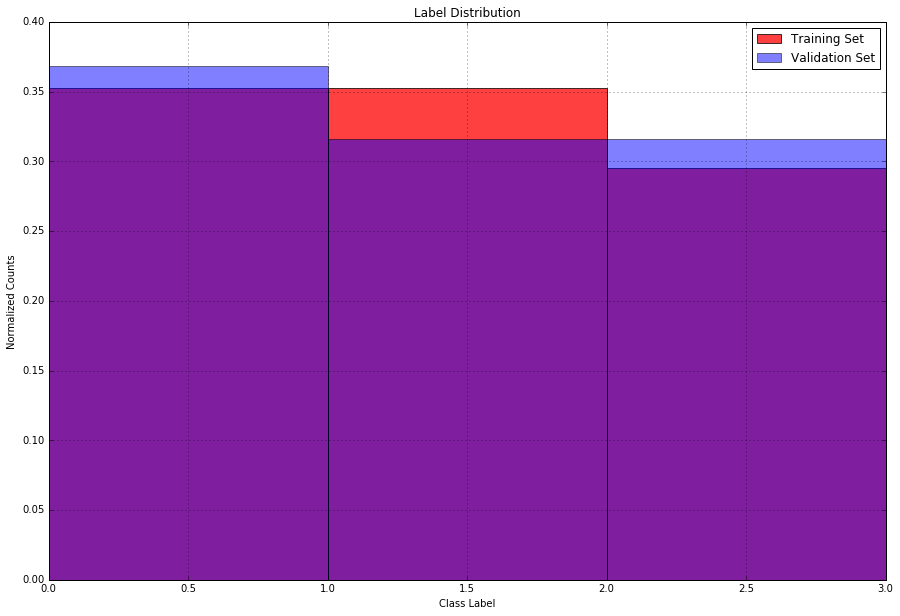

/home/diego/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


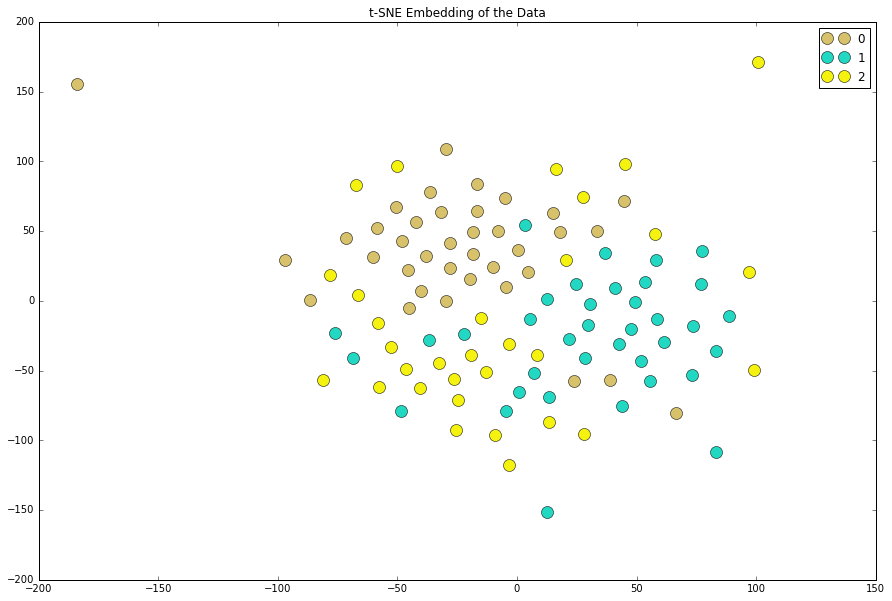

In [2]:
label_counts_train=np.bincount(y_train.astype(np.int))
label_counts_val=np.bincount(y_val.astype(np.int))

label_counts_train=label_counts_train/float(label_counts_train.sum())
label_counts_val=label_counts_val/float(label_counts_val.sum())

ind=np.arange(len(label_counts_train))
_, ax = plt.subplots(figsize=(15,10))
ax.bar(ind,label_counts_train,1, color='r',alpha=.75)
ind=np.arange(len(label_counts_val))
ax.bar(ind,label_counts_val,1, color='b',alpha=.5)
plt.legend(('Training Set','Validation Set'))
plt.xlabel('Class Label')
plt.ylabel('Normalized Counts')
plt.title('Label Distribution')
plt.grid()
plt.show()



model = TSNE(n_components=2,verbose=False)
X_proj=model.fit_transform(X_train)

colors = pd.tools.plotting._get_standard_colors(len(y_train), color_type='random')
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for i in xrange(0,3):
    plt.plot(X_proj[y_train==i,0],X_proj[y_train==i,1],
             marker='o',linestyle='',ms=12,
             alpha=1.,label=str(i))

plt.legend()
plt.title('t-SNE Embedding of the Data')
plt.show()

In [3]:
def labels2one_hot(y,num_labels):
    return (np.arange(num_labels)==y[:,None]).astype(np.float)


y_train=labels2one_hot(y_train,3)
y_test=labels2one_hot(y_test,3)
y_val=labels2one_hot(y_val,3)



In [4]:
#TODO

def xiaver_init(shape):    
    (fan_in, fan_out) = shape
    low = -4*np.sqrt(6.0/(fan_in + fan_out))
    high = 4*np.sqrt(6.0/(fan_in + fan_out))
    return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))                
                
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [5]:

batch_size = 25
num_hidden = 20
d=X_train.shape[1]
num_labels=3

graph = tf.Graph()
with graph.as_default():
    tf_train_x =tf.placeholder(tf.float32,shape=(batch_size, d))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_x = tf.constant(X_val.astype(np.float32))
    tf_test_x = tf.constant(X_test.astype(np.float32))
    tf_feature = tf.constant(X_train.astype(np.float32))
    
    W_1 = tf.Variable(tf.truncated_normal([d, num_hidden]))
    b_1 = tf.Variable(tf.zeros([num_hidden]))

    a_1=tf.matmul(tf_train_x,W_1)+b_1
    h_1=tf.nn.relu(a_1)
    
    p=tf.placeholder(tf.float32)
    h_1d=tf.nn.dropout(h_1,p)
    
    W_2 = xiaver_init((num_hidden,num_labels))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    
    a_2=tf.matmul(h_1d,W_2)+b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(a_2, tf_train_y))

    opt = tf.train.AdamOptimizer().minimize(loss)
    
    train_pred=tf.nn.softmax(a_2)
    val_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_x, W_1) + b_1),p),W_2)+b_2)
    test_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_x, W_1) + b_1),p),W_2)+b_2)
    
    feature_net=tf.nn.dropout(tf.nn.relu(tf.matmul(tf_feature,W_1) + b_1),p)
    

In [6]:
num_steps = 1000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    k=0
    for step in range(1,num_steps+1):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        k+=batch_size
    
        if k > y_train.shape[0]:
        #print("Reshuffling")
            idx=np.random.permutation(y_train.shape[0])
            X_train=X_train[idx,:]
            y_train=y_train[idx]
            k=0
    
    # Generate a minibatch.
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_x : batch_data, tf_train_y : batch_labels, p:.4}
        _, l, predictions= session.run(
          [opt, loss, train_pred], feed_dict=feed_dict)
    
        if step % 100 == 0 or step==1:
            print "Iteration %d Minibatch Loss %f Accuracy %.1f%%" %(step,l,accuracy(predictions,batch_labels))
            print "Validation Accuracy %f%%\n" % (accuracy(val_pred.eval({p:1}),y_val))
    
    print "Test Accuracy %f%%\n" % (accuracy(test_pred.eval({p:1}),y_test)) 
    X_feature=feature_net.eval({p:1})

Initialized
Iteration 1 Minibatch Loss 16.733463 Accuracy 44.0%
Validation Accuracy 26.315789%

Iteration 100 Minibatch Loss 7.375482 Accuracy 44.0%
Validation Accuracy 47.368421%

Iteration 200 Minibatch Loss 4.710368 Accuracy 72.0%
Validation Accuracy 68.421053%

Iteration 300 Minibatch Loss 6.803255 Accuracy 64.0%
Validation Accuracy 94.736842%

Iteration 400 Minibatch Loss 1.589019 Accuracy 76.0%
Validation Accuracy 94.736842%

Iteration 500 Minibatch Loss 3.466612 Accuracy 64.0%
Validation Accuracy 94.736842%

Iteration 600 Minibatch Loss 1.668293 Accuracy 80.0%
Validation Accuracy 94.736842%

Iteration 700 Minibatch Loss 1.788332 Accuracy 76.0%
Validation Accuracy 94.736842%

Iteration 800 Minibatch Loss 1.903513 Accuracy 80.0%
Validation Accuracy 94.736842%

Iteration 900 Minibatch Loss 2.144674 Accuracy 72.0%
Validation Accuracy 94.736842%

Iteration 1000 Minibatch Loss 1.502761 Accuracy 68.0%
Validation Accuracy 94.736842%

Test Accuracy 98.148148%



In [7]:
def onehot2labels(y):
    return y.argmax(axis=1).astype(np.float32)

y_train=onehot2labels(y_train)

model = TSNE(n_components=2,verbose=False)
X_proj=model.fit_transform(X_feature)

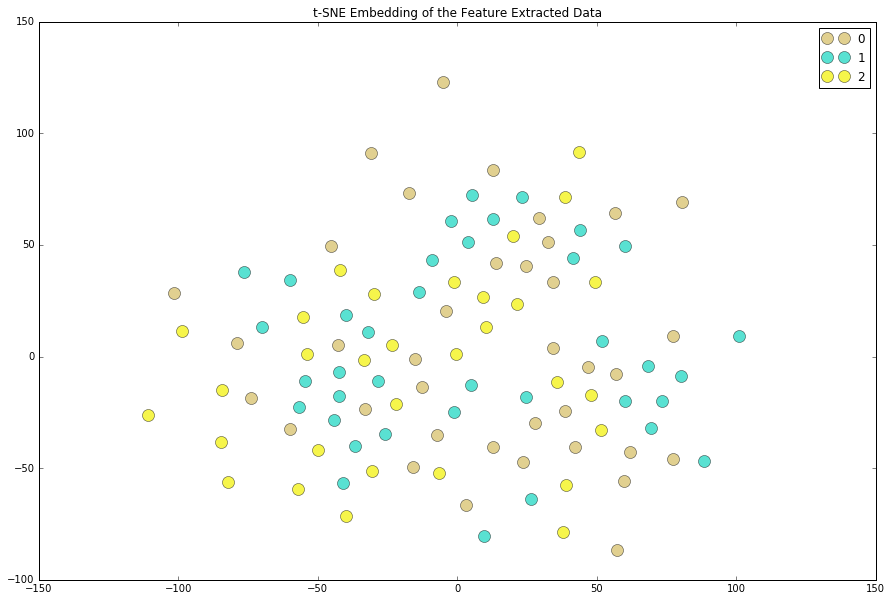

In [8]:
colors = pd.tools.plotting._get_standard_colors(len(y_train), color_type='random')
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for i in xrange(0,3):
    plt.plot(X_proj[y_train==i,0],X_proj[y_train==i,1],
             marker='o',linestyle='',ms=12,
             alpha=.75,label=str(i))
plt.legend()
plt.title('t-SNE Embedding of the Feature Extracted Data')
plt.show()